## Analysis of basins containing intra-basin transfers on the east and west sides of the Continental Divide

Theodore Barnhart | 24 April 2015

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
%matplotlib inline

In [12]:
data = pd.read_hdf('./budyko_working_WSC_HUC8.hdf','df')

In [13]:
def budyko(DI):
    return np.sqrt(DI*np.tanh(1/DI)*(1-np.exp(-DI)))
data['PETpenvic_P'] = data['PETpenmanvic']/data['P'] # compute the dryness index
data['ET_P'] = data['ET']/data['P'] # compute the evaporative index
DI = np.arange(0,50.001,0.001) # make a range to compute the budyko curve over
EI = budyko(DI) # compute the Budyko Curve
data['pred_EI'] = data['PETpenvic_P'].apply(budyko) # compute the predicted evaportative index for each cell given its aridity
data['Q_P'] = 1.-data['ET_P'] # compute actual runoff for each cell 
data['Qpred_P'] = 1.-data['pred_EI'] # compute predicted runoff for each cell
data['Qanom_P'] = data['Q_P']-data['Qpred_P'] # compute the anomoly (actual - predicted)
data['Q'] = data.Q_P*data.P # compute Q not normalized by P
data['Qanom'] = data.Qanom_P*data.P

In [14]:
data['side'] = np.nan

In [15]:
data.loc[(data.huc4 == 1018) | (data.huc4 == 1019) | (data.huc4 == 1102),'side'] = 1 # east draining river

In [16]:
data.loc[(data.huc4 == 1401) | (data.huc4 == 1402),'side'] = 2 # west draining rivers

In [17]:
xx = 'snowmelt'
yy = 'Qanom_P'

mods = []

for side in [1,2]:
    X = data.loc[data.side==side,xx]
    y = data.loc[data.side==side,yy]
    X = sm.add_constant(X)
    
    mods.append(sm.OLS(y,X).fit())

In [18]:
names = ['East Side','West Side']
names2 = []
for name,mod in zip(names,mods):
    names2.append(name+'\n pvalue='+str(round(mod.f_pvalue,3))+', r$^2$='+str(round(mod.rsquared,3)))

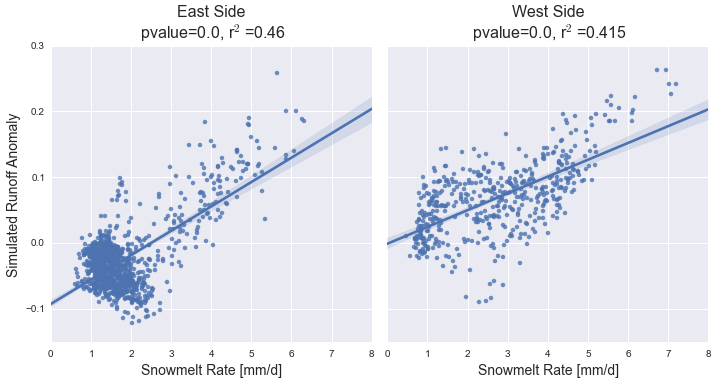

In [19]:
fig = plt.figure(figsize=(12,8));
p = sn.lmplot('snowmelt','Qanom_P',data,col='side');
for name,ax in zip(names2,p.axes.flat):
    ax.set_title(name, fontsize=16);
    ax.set_xlabel('Snowmelt Rate [mm/d]', fontsize = 14);

p.axes.flat[0].set_ylabel('Simulated Runoff Anomaly', fontsize = 14);

In [23]:
sm.stats.anova_lm(mods[0],mods[1])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1018,1.537720,0,NaN,NaN,NaN
1,485,0.909912,533,0.627809,0.627831,1


There is no difference between the east and west sides of the divide at the huc10 scale. 

### Future Work:
- use larger HUC8 or HUC6 basins
- look more closely at paired basins on either side of each transfer
- use WRF-Hydro headwaters simulation (maybe has smaller grid-cells, therefore more data to compare on either side of the divide?)
- Use an interannual analysis of hydrologic partitioning to increase the number of observations on each side of the divide. 